In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl

In [3]:
with open("weather.txt","r") as f:
    all_lines = f.read()
    
lines = all_lines.split('\n')
numbers = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])
NR = numbers.shape[0]
seed=42
np.random.seed(seed)
np.random.shuffle(numbers)
# Numbers = np.zeros_like(numbers)
# for i, y in enumerate(numbers.T):
#     Numbers[:,i] = (np.argsort(y.flatten()).argsort()/y.size).reshape(y.shape)

In [6]:
c = 0
# conditional
numbers[:,c] = (np.argsort(numbers[:,c].flatten()).argsort()/numbers[:,c].size).reshape(numbers[:,c].shape) 
train = numbers[:NR//2]
test = numbers[NR//2:]
#unconditional
# train = Numbers[:NR//2]
# test = Numbers[NR//2:]

In [7]:
with open("shuttle.trn","r") as f:
    all_lines = f.read()
    
lines = all_lines.split('\n')
train = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])

with open("shuttle.tst","r") as f:
    all_lines = f.read()
    
lines = all_lines.split('\n')
test = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])

seed = 2
train = train[seed::3]
test = test[seed::3]
size = train.shape[0]

print(train.shape, test.shape)

numbers = np.concatenate([train,test])
numbers[:,c] = (np.argsort(numbers[:,c].flatten()).argsort()/numbers[:,c].size).reshape(numbers[:,c].shape)
train = numbers[:size]
test = numbers[size:]
print(train.shape, test.shape)

(14500, 10) (4833, 10)
(14500, 10) (4833, 10)


In [9]:
import sys
sys.path.insert(0, '/home/nina/CopulaGP/')
from marginal import heuristic_element_order
order = heuristic_element_order(numbers) # different for test, but we follow the vine.R by Hernandez-Lobato
order

array([7, 4, 9, 8, 0, 6, 2, 5, 1, 3])

In [756]:
import marginal as mg
X = train[:,c]
Xt = test[:,c]
Y_raw = train[:,order[order!=c]]
Yt_raw = test[:,order[order!=c]]
# conditional
Y = np.zeros_like(Y_raw)
Yt = np.zeros_like(Yt_raw)
for i, (y,yt) in enumerate(zip(Y_raw.T,Yt_raw.T)):
    Y[:,i] = mg.fast_signal2uniform(y,X)
    Yt[:,i] = mg.fast_signal2uniform(y,X,Y_=yt,X_=Xt)
    print(i)
# unconditional
# Y = Y_raw
# Yt = Yt_raw

0
1
2
3
4
5
6
7
8


In [19]:
import MI
Hs = []
for i in range(1,9):
    _,H = MI.BI_KSG(numbers[:,0].reshape(-1,1),numbers[:,i].reshape(-1,1))
    print(H)
    Hs.append(H)
# entropies = []
# for i in range(1,numbers.shape[-1]):
#     _,counts = np.unique(numbers[:,i],return_counts=True)
#     counts = counts/np.sum(counts)
#     entropies.append((np.log(counts)*counts).sum())
# np.mean(entropies)

-7.420557874968377
-4.203508964679052
-7.29818629924711
-7.084938963639161
-2.557310070640135
-4.046568174837203
-2.2781650372375735
-6.851544081473325


(14500,)

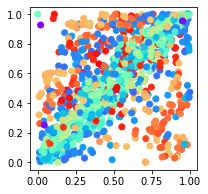

In [757]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 4
plt.scatter(*Yt[::skip,[0,4]].T,color=cm.rainbow(Xt[::skip]))
X.shape

In [758]:
def normalize_Y(Y_all,min,max):
    return (Y_all - min)/(max-min)*0.998+0.001
d = {}
d['X'] = X
d['Xt'] = Xt
min = np.concatenate([Y,Yt]).min(0)
max = np.concatenate([Y,Yt]).max(0)
d['Y'] = normalize_Y(Y,min,max)
d['Yt'] = normalize_Y(Yt,min,max)
d['X_label'] = 'latitude'
d['Y_labels'] = ['time','licks','neuropil'] 
d['comment'] = 'All variables were sorted together (emp. kendalls tau), \
                    thenlatitude moved to the first position'

# with open(f"/home/nina/CopulaGP/benchmarks/weather{seed}.pkl",'wb') as f:
#     pkl.dump(d,f)
with open(f"/home/nina/CopulaGP/benchmarks/shuttle{seed}.pkl",'wb') as f:
    pkl.dump(d,f)

In [759]:
# plt.figure(figsize=(3,3))
# plt.scatter(*d['Y'][:,[1,4]].T)
# d['Y'].shape
d['X'].shape

(14500,)

In [457]:
# import select_copula
# device='cuda:0'
# train_x = torch.tensor(X).float().to(device)
# train_y = torch.tensor(Y[:,[0,1]]).clamp(0.001,0.999).float().to(device)
# out = '/home/nina/CopulaGP/synthetic_data/outputs'
# (likelihoods, waic) = select_copula.select_with_heuristics(X,Y[:,[0,1]],device,'weather',out,0,1,
#                                     train_x=train_x, train_y=train_y) #[torch.randperm(NSamp)]

In [175]:
from train import conf
import glob
import tqdm
import utils
import bvcopula
from vine import CVine

seed='2'
exp_pref = f'shuttleS{seed}'
path_models = f"{conf.path2outputs}/{exp_pref}"
path_models

'/home/nina/outputs/shuttleS2'

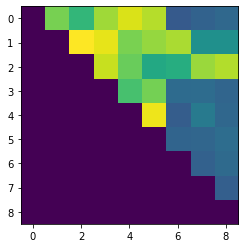

In [176]:
list_files = glob.glob(f"{path_models}/models_*.pkl")
with open(f"{path_models}/models_layer0.pkl","rb") as f:
    results = pkl.load(f)
NN = len(results)+1
WAICs = np.zeros((NN,NN))
WAICs[0,1:] = [a[3] for a in results]
for layer in range(1,len(results)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        res = pkl.load(f)
    WAICs[layer,(layer+1):] = [a[3] for a in res]
plt.imshow(WAICs[:])

In [177]:
device = "cuda:0"

# create linspace
# N_points = 50
# train_x = torch.linspace(0,1,N_points).to(device)

with open(f"shuttle{seed}.pkl","rb") as f:
    d = pkl.load(f)

#real
X,Y = d['X'], d['Y']
#utils.standard_loader(f"{conf.path2data}/{exp_pref}_layer0.pkl")
# N_points = 200
train_x = torch.tensor(X, device=device).float()
train_y = torch.tensor(Y, device=device).float()
test_x = torch.tensor(d['Xt'], device=device).float()
test_y = torch.tensor(d['Yt'], device=device).float()
# train_x = train_x[torch.randperm(train_x.numel())[:N_points]]

x = test_x
y = test_y
N_points=x.shape[0]

# x.shape

In [178]:
copula_layers, likelihood_layers, fs_layers = [], [], []
for layer in tqdm.tqdm(range(0,NN-1)):
    copulas, liks, fs = [], [], []
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        results = pkl.load(f)
    out_dir = f'{path_models}/layer{layer}'
    for n,res in enumerate(results):
        if res[1]!='Independence':
            likelihoods = res[0]
            weights_file = f"{out_dir}/model_{exp_pref}_{layer}-{layer+n+1}.pth"
            model = utils.get_model(weights_file, likelihoods, device)
            liks.append(model.likelihood)
            with torch.no_grad():
                f = model(x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                fs.append(f)
        else:
            copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula]))
            fs.append(None)
            liks.append([bvcopula.IndependenceCopula_Likelihood()])
#     else:
#         for n in range(NN-1-layer):
#             copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                         torch.ones(1,N_points,device=device),
#                         [bvcopula.IndependenceCopula]))
#             fs.append(None)
#             liks.append([bvcopula.IndependenceCopula_Likelihood()])
    copula_layers.append(copulas)
    likelihood_layers.append(liks)
    fs_layers.append(fs)

100%|██████████| 8/8 [00:00<00:00, 47.37it/s]


In [179]:
vine = CVine(copula_layers,x,device=device).truncate(5)
copgpT = vine.log_prob(y).mean()
vine = CVine(copula_layers,x,device=device)
copgp = vine.log_prob(y).mean()
(copgp,copgpT)
# X.shape

(tensor(4.6301, device='cuda:0'), tensor(3.7191, device='cuda:0'))

In [180]:
#redirect logging here
def train4entropy(x,y,xt,likelihood,shuffle=False):
    Nvar = y.shape[-1]
    data_layers = [torch.tensor(y).clamp(0.001,0.999).float().to(device)]
    copula_layers, model_layers = [], []
    for m in range(0,Nvar-1):
        copulas, layer, models = [], [], []
        for n in range(1,Nvar-m):
            print(m,n+m)
            if shuffle:
                x = x[torch.randperm(NSamp)]
            samples = data_layers[-1][...,[n,0]]
            waic, model = bvcopula.infer(likelihood,x,samples,device=device) 
            print(f'WAIC: {waic}')
            if shuffle:
                x = x[torch.randperm(NSamp)]
            with torch.no_grad():
                f = model(x).mean
                copula = model.likelihood.get_copula(f)
                layer.append(copula.ccdf(samples))
                models.append(model)
                
                ft = model(xt).mean
                copulat = model.likelihood.get_copula(ft)
                copulas.append(copulat)
        data_layers.append(torch.stack(layer,dim=-1))
        copula_layers.append(copulas)
        model_layers.append(models)
    print('Trained')
    vine_trained = CVine(copula_layers,xt,device=device)
#     entropies = vine_trained.entropy(sem_tol=0.1, mc_size=1000, v=True)
    return copula_layers, model_layers, vine_trained#, entropies

In [151]:
likelihood = [bvcopula.GaussianCopula_Likelihood()]
%time copula_layers, models, vine = train4entropy(train_x,train_y,test_x,likelihood, shuffle=False)

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


0 1
WAIC: -0.2910406291484833
0 2
WAIC: -0.022177960723638535
0 3
WAIC: -0.24528378248214722
0 4
WAIC: -0.5649643540382385
0 5
WAIC: -0.49136149883270264
0 6
WAIC: -0.003698203479871154
0 7
WAIC: -0.0017108517931774259
0 8
WAIC: -0.00025834262487478554
1 2
WAIC: -0.254146009683609
1 3
WAIC: -0.24017022550106049
1 4
WAIC: -0.23091907799243927
1 5
WAIC: -0.24927978217601776
1 6
WAIC: -0.14193055033683777
1 7
WAIC: -0.036047354340553284
1 8
WAIC: -0.0005853186012245715
2 3
WAIC: -0.34637442231178284
2 4
WAIC: -0.055983223021030426
2 5
WAIC: -0.05516083538532257
2 6
WAIC: -0.02970758080482483
2 7
WAIC: -0.1384006291627884
2 8
WAIC: -0.005632654298096895
3 4
WAIC: -0.07367432117462158
3 5
WAIC: -0.037610962986946106
3 6
WAIC: -0.028000326827168465
3 7
WAIC: -0.03234613686800003
3 8
WAIC: -0.00023477528884541243
4 5
WAIC: -0.6243498921394348
4 6
WAIC: -0.005916230380535126
4 7
WAIC: -0.0013180077075958252
4 8
WAIC: -0.0008425269625149667
5 6
WAIC: -0.0037598260678350925
5 7
WAIC: -0.00079781

In [153]:
vine = CVine(copula_layers,test_x,device=device).truncate(5)
logprobT = vine.log_prob(test_y).mean()
vine = CVine(copula_layers,test_x,device=device)
logprob = vine.log_prob(test_y).mean()
(logprob,logprobT)

(tensor(3.8267, device='cuda:0'), tensor(3.0499, device='cuda:0'))

In [154]:
d['copula_layers'] = copula_layers
d['vine'] = vine 
d['copgp_logprob'] = copgp.item()
d['copgp_logprob_trunc5'] = copgpT.item() #cut 5 last layers, the same way as Hernandez-Lobato did in ICML
d['logprob'] = logprob.item()
d['logprob_trunc5'] = logprobT.item()
with open(f"res_shuttle{seed}.pkl","wb") as f:
    pkl.dump(d,f)

In [118]:
def report(arr):
    return f"{arr.mean():.3f}$\pm${arr.std():.3f}"

In [119]:
# np.array([3.1495,2.7663,2.7743]).mean() #weather col 3 (seed 42,43,44)
report(np.array([1.7590,1.5948,1.6253])) #weather col 3 T2 (seed 42,43,44,45)

'1.662$\\pm$0.062'

In [661]:
report(np.array([1.28,1.61,1.23])) #weather col 2
report(np.array([])) #weather col 2 T2

0.16858891488535727

In [ ]:
# np.array([2.176]).std() #weather col 1

In [186]:
#Mixture
report(np.array([5.3181,4.9605,5.0673])) #shuttle (shift 0,1,2, every 4th element of the original UCL dataset)
# report(np.array([4.5637,4.2347,4.1797])) #T3


'5.115$\\pm$0.150'

In [156]:
#Only Gauss
report(np.array([4.4774,3.8267,4.2878])) #shuttle
# report(np.array([3.7960,3.0499,3.3745])) #T3

'4.197$\\pm$0.273'

In [187]:
#Single
report(np.array([4.6135,4.1668,4.6301])) # shuttle
# report(np.array([4.1533,3.4038,3.7191])) # T3

'4.470$\\pm$0.215'